In [ ]:
%%capture --no-stderr
%pip install langgraph langchain-google-genai langchain-community langchain-core tavily-python

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ["GEMINI_API_KEY"] = userdata.get("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "learn_agentic_ai"

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage
from langchain.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from openpyxl import Workbook, load_workbook
from datetime import datetime

memory = MemorySaver()

class State(TypedDict):
    query: str
    messages: Annotated[List[AnyMessage], add_messages]
    category: str
    sentiment: str
    human_feedback: str

@tool
def get_order_update(order_id: int) -> State:
    """Provided update on a customer's order based on order id
    """
    return "Your order ID is {order_id} - shipped."

@tool
def get_product_information(order_id: int) -> State:
    """Provides information about a product based on the order_id
    """
    return "This product is a top-selling item with excellent reviews."

@tool
def submit_complaint(user_id: int, complaint: str) -> str:
    """
    Records a user complaint into an Excel file.
    """
    file_path = 'user_complaints.xlsx'
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    if os.path.exists(file_path):
        # Load the existing workbook and select the active worksheet
        workbook = load_workbook(file_path)
        sheet = workbook.active
    else:
        # Create a new workbook and worksheet with headers
        workbook = Workbook()
        sheet = workbook.active
        sheet.append(['Timestamp', 'User ID', 'Complaint'])

    # Append the new complaint data
    sheet.append([timestamp, user_id, complaint])

    # Save the workbook
    workbook.save(file_path)

    return f"Your complaint has been recorded. Reference number: {sheet.max_row - 1}"


tools = [
    get_order_update,
    get_product_information,
    submit_complaint
]

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=os.environ["GEMINI_API_KEY"], model="gemini-2.0-flash-exp", temperature=0.3)

llm_with_tools = llm.bind_tools(tools)

In [ ]:
def categorize_and_analyze_sentiment(state: State) -> Command[Literal["assistant", "escalate"]]:
    """
    Determines the category and sentiment of the customer query.

    Categories:
    - Order Issues
    - Delivery Status
    - Product Information
    - Feedback
    - Complaints
    - General

    Sentiments:
    - Positive
    - Neutral
    - Negative
    """
    print("categorize_and_analyze_sentiment node is working")

    class CategorizeAndSentimentOutput(BaseModel):
        category: str = Field(description="Predefined category of the query. Options: Order Issues, Delivery Status, Product Information, Feedback, Complaints, General.")
        sentiment: str = Field(description="The sentiment of the query: Positive, Neutral, or Negative")

    structured_llm = llm_with_tools.with_structured_output(CategorizeAndSentimentOutput)

    prompt = ChatPromptTemplate.from_template(
        """Categorize the following customer query into one of these categories:
        - Order Issues
        - Delivery Status
        - Product Information
        - Feedback
        - Complaints
        - General

        Analyze the sentiment as Positive, Neutral, or Negative.

        The user message is: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["messages"][-1]))

    goto = "escalate" if output.sentiment == "Negative" else "assistant"

    return Command (
        update={"category": output.category, "sentiment": output.sentiment},
        goto=goto
    )

def assistant(state: State) -> State:
    system_msg = f"""
    You are a friendly and helpful customer support assistant.
    You are here to assist customers with their inquiries and resolve their issues efficiently and effectively.

    Based on the query, use the avaiable tools or
    generate a response directly.

    Available tools:
    - get_order_update: Retrieves the latest update on a customer's order.
    - submit_complaint: Records a user complaint into the system.
    - get_product_information: Provides information about a specific product.

    Important: If the user's query is off-topic or unrelated to customer support, politely guide them back to the main topic by saying something like: "I understand your concern, but I'm here to help with customer support related questions. Could you please rephrase your query or ask a question related to our products or services?
    """

    user = f"""
    The message history is: {state["messages"]}
    The customer's query is categorized as: {state["category"]}
    The sentiment of the query is: {state["sentiment"]}"""

    response = llm_with_tools.invoke([SystemMessage(content=system_msg), HumanMessage(content=user)])

    return {"messages": response}


def escalate(state: State) -> Command[Literal[END]]:
    """
    Escalates the query to a human agent when the sentiment is negative.
    """
    return Command(
        update={"human_feedback": "Escalated to human agent due to negative sentiment."},
        goto=END
    )

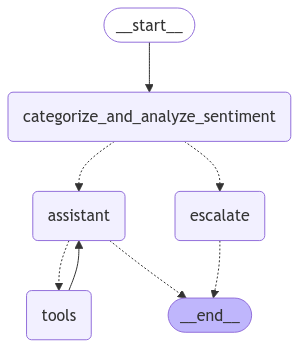

In [ ]:
  graph_builder = StateGraph(State)

  graph_builder.add_node("categorize_and_analyze_sentiment", categorize_and_analyze_sentiment)
  graph_builder.add_node("assistant", assistant)
  graph_builder.add_node("tools", ToolNode(tools))
  graph_builder.add_node("escalate", escalate)

  graph_builder.add_edge(START, "categorize_and_analyze_sentiment")
  graph_builder.add_conditional_edges("assistant", tools_condition)
  graph_builder.add_edge("tools", "assistant")

  graph = graph_builder.compile(checkpointer=memory)

  display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": 1}}

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": user_input}, config):
        for node_name, value in event.items():
            if node_name == "assistant":
                print("Assistant:", value["messages"].content)
            elif node_name == "escalate":
                print("Escalation:", value["human_feedback"])
            elif node_name == "categorize_and_analyze_sentiment":
                print("Category:", value["category"])
                print("Sentiment:", value["sentiment"])
            else:
                print("ToolNode message:", value)


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

User: Hello
categorize_and_analyze_sentiment node is working
Category: General
Sentiment: Neutral
Assistant: Hello! How can I help you today?
User: Why is the sky blue ?
categorize_and_analyze_sentiment node is working
Category: General
Sentiment: Neutral
Assistant: I understand your concern, but I'm here to help with customer support related questions. Could you please rephrase your query or ask a question related to our products or services?
User: Where is my book order right now ?
categorize_and_analyze_sentiment node is working
Category: Delivery Status
Sentiment: Neutral
Assistant: Could you please provide the order ID, so I can check the delivery status for you?
User: 90611
categorize_and_analyze_sentiment node is working
Category: General
Sentiment: Neutral
Assistant: 
ToolNode message: {'messages': [ToolMessage(content='Your order ID is 90611 - shipped.', name='get_order_update', id='58d6d323-467a-43f8-a506-c27190f51818', tool_call_id='a78371bb-61e2-4835-8121-e8b1c1b54db6')]}
A